# Double Jet

ML scores over simulation time

In [1]:
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.DoubleJetPlot import *

Get initial arguments from class

In [4]:
from gpuocean.utils import DoubleJetCase

In [5]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## MLMC

In [6]:
MLMCsource_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLMC/2023-11-07T13_32_38"

In [7]:
Ts = np.load(MLMCsource_path+"/MLts.npy")

In [8]:
MLMCscores = np.load(MLMCsource_path+"/MLscores.npy")
MLMCdiff_scores = np.load(MLMCsource_path+"/MLdiff_scores.npy")

## MLDA

In [9]:
MLDAsource_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-03T17_30_50"

In [10]:
Ts = np.load(MLDAsource_path+"/MLts_posterior.npy")

In [11]:
MLDAscores_prior = np.load(MLDAsource_path+"/MLscores_prior.npy")
MLDAdiff_scores_prior = np.load(MLDAsource_path+"/MLdiff_scores_prior.npy")

MLDAscores_posterior = np.load(MLDAsource_path+"/MLscores_posterior.npy")
MLDAdiff_scores_posterior = np.load(MLDAsource_path+"/MLdiff_scores_posterior.npy")

In [12]:
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues)
cmap.set_array([])

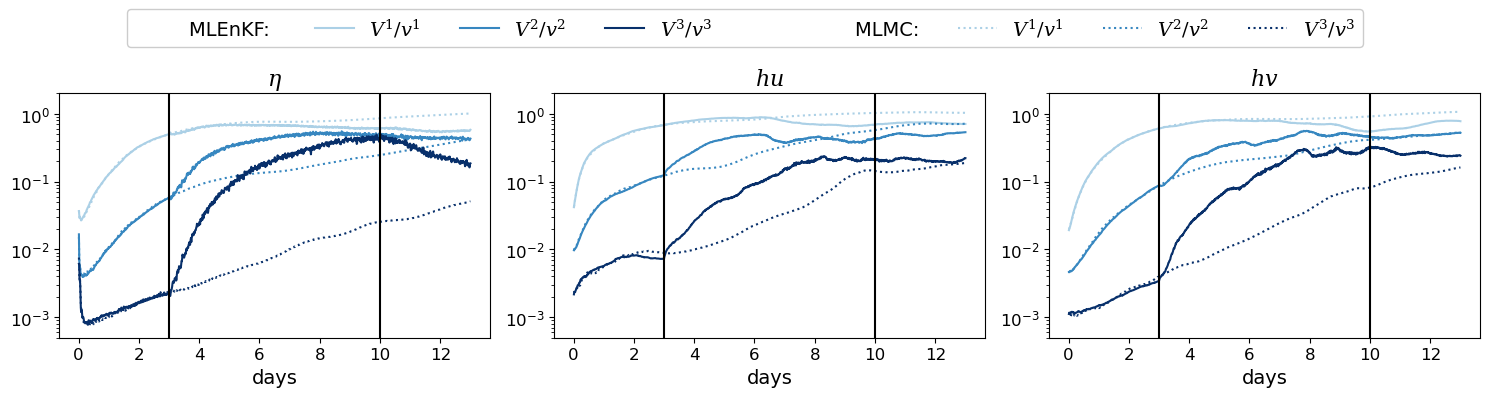

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15,3.5))
plt.rcParams["mathtext.fontset"] = "dejavuserif"


for i in range(3):

    for l_idx in range(1, len(MLDAscores_posterior[0])):
        axs[i].plot(Ts/3600/24,  MLDAdiff_scores_posterior[:,l_idx,i]/MLDAscores_posterior[:,l_idx,i], 
                    c=cmap.to_rgba(1/3*l_idx), label=r"$V^"+str(l_idx)+"/v^"+str(l_idx)+"$")
        axs[i].plot(Ts/3600/24,  MLMCdiff_scores[:,l_idx,i]/MLMCscores[:,l_idx,i], ls="dotted", 
                    c=cmap.to_rgba(1/3*l_idx), label=r"$V^"+str(l_idx)+"/v^"+str(l_idx)+"$")
        
    axs[i].set_yscale("log")

h, l = axs[i].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]*2

handles = ph[1:] + h[::2] + ph[:1] + h[1::2]
labels = ["MLEnKF: "] + l[::2] + ["        MLMC:"] + l[1::2]

leg = fig.legend(handles, labels, loc="upper center", ncol=10, bbox_to_anchor=(0.5, 1.15), framealpha=1.0, fontsize=14)

axs[0].set_title(r"$\eta$", fontsize=16)
axs[1].set_title(r"$hu$", fontsize=16)
axs[2].set_title(r"$hv$", fontsize=16)

for ax in axs:
    ax.axvline(3, c="black")
    ax.axvline(10, c="black")

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.set_ylim((5e-4, 2))
    ax.set_xlabel("days", fontsize=14)

plt.tight_layout()

plt.savefig("DoubleJet-MLDA-PostProcessing-MLScores4paper.pdf", bbox_inches="tight", dpi=300)